In [16]:
import numpy as np

from sklearn.linear_model import LogisticRegression
# 多項式・交互作用特徴量の生成
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
import japanize_matplotlib

## 訓練データの読み込み

In [17]:
# CSVファイル読み込み（訓練データ）
df_train = pd.read_csv('train.csv')
df_train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0


In [18]:
# 性別を変換する（訓練データ）
gemder=pd.get_dummies(df_train.loc[:,['Gender']])
df_train['Female']=gemder.loc[:,['Gender_Female']]
df_train['Male']=gemder.loc[:,['Gender_Male']]
df_train.drop(columns=['Gender'],inplace=True)
df_train.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Female,Male
0,59,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0,0,1
1,69,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1,0,1
2,65,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0,0,1
3,65,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1,0,1
4,22,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0,1,0


In [19]:
# 重複データを削除する
# df.drop_duplicates(inplace=True)
# インデックスを採番し直す
#df.reset_index(drop=True, inplace=True)

## 評価データの読み込み

In [20]:
# CSVファイル読み込み（評価データ）
df_vat = pd.read_csv('test.csv')
df_vat.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078


In [21]:
# 性別を変換する（評価データ）
gemder=pd.get_dummies(df_vat.loc[:,['Gender']])
df_vat['Female']=gemder.loc[:,['Gender_Female']]
df_vat['Male']=gemder.loc[:,['Gender_Male']]
df_vat.drop(columns=['Gender'],inplace=True)
df_vat.head()

,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Female,Male
0,25,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006,0,1
1,26,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562,1,0
2,64,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579,0,1
3,65,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070,0,1
4,34,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078,1,0


## データ加工

In [22]:
def xConv(x_tmp,):
    # T_Bil、D_Bilの変換
    bins1 = [0, 0.6,  0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.3, 1.4, 1.5, 1.8, 100]
    bins2 = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 100]
    x_tmp=comCutCnnect(x_tmp, bins1, 'T_Bil' , bins2, 'D_Bil' )
    
    # T_Bil、D_Bilの変換
    bins1 = [0, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 50, 100, 125,1500]
    bins2 = [0, 20, 25,  30, 35,  40, 50, 60, 70, 80, 100, 140, 180,900]
    x_tmp=comCutCnnect(x_tmp, bins1, 'ALT_GPT' , bins2, 'AST_GOT' )
       
    return x_tmp


def comCutCnnect(x_tmp,bins1 ,col1, bins2 ,col2 ):   
    X_cut_1 = pd.cut(x_tmp[col1], bins=bins1, labels=False)
    X_cut_2 = pd.cut(x_tmp[col2], bins=bins2, labels=False)
    X_cut = pd.DataFrame(np.array(X_cut_1) * np.array(X_cut_2) , columns={col1})
    x_tmp.drop(columns=[col1 , col2], inplace=True, axis=1)
    x_tmp = pd.concat([x_tmp, X_cut], axis=1)
    return x_tmp

   

In [26]:
# 説明変数（訓練データ）
x_tmp=df_train.loc[:,['Age',  'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio','Female','Male']]
x_tmp=xConv(x_tmp)
x_train = np.array(x_tmp)
print(x_tmp.head())
# 目的変数（訓練データ）
y_train = np.array(df_train.loc[:,['disease']])


# 説明変数（評価データ）
x_tmp=df_vat
x_tmp=xConv(x_tmp)
print(x_tmp.head())
x_vat = np.array(x_tmp)

   Age         ALP        TP       Alb  AG_ratio  Female  Male  T_Bil  ALT_GPT
0   59  220.178691  6.815731  3.112276  1.006802       0     1      9        4
1   69  221.218413  6.889608  3.051521  0.751346       0     1     18       70
2   65  320.770533  5.947767  2.489167  0.774952       0     1      1       12
3   65  369.278160  6.967183  3.613837  0.988155       0     1     20       54
4   22  222.782025  5.837537  3.068697  1.026654       1     0     30       77
   Age         ALP        TP       Alb  AG_ratio  Female  Male  T_Bil  ALT_GPT
0   25  214.448679  6.817903  3.600752  1.288006       0     1     12        0
1   26  234.136816  6.795433  3.111043  1.030562       1     0      8        0
2   64  216.039909  7.524030  3.627621  1.278579       0     1      9        4
3   65  200.901130  6.829109  3.626758  1.275070       0     1     12        4
4   34  208.705835  8.663530  4.170750  1.280078       1     0      2       14


## 訓練

In [27]:
X_train,X_test,Y_train,Y_test=train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

In [28]:
# モデルの学習・予測
model = LogisticRegression()
model.fit(X_train, Y_train)

C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\takasaki\Anaconda3\envs\matplotlib\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

## 検証データを使って予測値の検証

In [29]:
# 検証 <-訓練データ 
model.score(X_train ,Y_train)

0.8288854003139717

In [30]:
# 検証 <-検証データ
# (検証データと値が近いなら信用できる。
#  どこまでの差異を近いとするかはそれぞれ
#  判断する必要がある。)
model.score(X_test,Y_test)

0.8403755868544601

## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

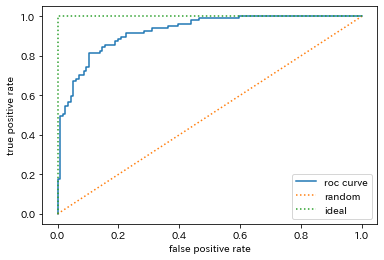

[1.99949849 0.99949849 0.98991354 0.98655882 0.83693707 0.83392795
 0.81818309 0.8101738  0.79456655 0.78258746 0.75962914 0.73703379
 0.71166721 0.70477657 0.63644352 0.6336293  0.62535265 0.61855042
 0.6135548  0.60023095 0.59615601 0.57939154 0.55361664 0.54075493
 0.48139902 0.38866219 0.37905354 0.37465068 0.37242711 0.36291764
 0.35478668 0.33294499 0.3160103  0.31600596 0.30333894 0.28988857
 0.28711206 0.27417852 0.26891028 0.25082548 0.24440677 0.23654681
 0.23299846 0.21277469 0.2120567  0.19534796 0.19381322 0.18537337
 0.18052746 0.17792942 0.17372121 0.1502192  0.15006976 0.05237902]


In [31]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
y_pred = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=y_pred)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [32]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=Y_test, y_score=y_pred)
print("AUC:", auc_score)

AUC: 0.9242801279772485


## 予測する

In [40]:
y_pred = model.predict_proba(df_vat)[:, 1]
y_pred=np.array(y_pred.round() ,dtype=np.int64)
df_out = pd.DataFrame(y_pred, columns=['val'])
df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)

In [ ]:
#from collections import Counter
#print(Counter(y_predict))

## モデルの保存

In [35]:
#import pickle
#with open('model.pickle', mode='wb') as fp:
#    pickle.dump(model, fp)